In [1]:
sc.setLogLevel("ERROR")

In [2]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer

In [3]:
# read parquet files
hi_train_20 = spark.read.parquet("gs://st446-final-zqh/train_20.parquet")
hi_test_20 = spark.read.parquet("gs://st446-final-zqh/test_20.parquet")

In [4]:
hi_train_20.show(5)

+--------------------+--------------------+------+----------+--------------+-------+-----------+-------------+-----------------+
|            business|                user|rating|avg_rating|num_of_reviews|user_id|business_id|rating_binary|__index_level_0__|
+--------------------+--------------------+------+----------+--------------+-------+-----------+-------------+-----------------+
|0x7c006dfc54507bd...|11114289633266697...|   4.0|       4.6|          4439|  99416|       8083|            0|           152102|
|0x7c006dc18be0a20...|11417430709901921...|   1.0|       3.6|            33| 126495|       7134|            0|           133648|
|0x7c0067766f623ec...|11755365066548762...|   5.0|       4.9|           175| 156269|       5919|            1|           113401|
|0x7c06e58276ac7d6...|10460357243155990...|   5.0|       4.6|           146|  41044|      10673|            1|           205904|
|0x7c0014db7086816...|10826976370014529...|   5.0|       4.4|            38|  73546|       3993| 

In [5]:
hi_train_20.count()

225049

In [6]:
hi_test_20.count()

25006

In [12]:
def grid_search(train_data, test_data):
    best_rmse = float("inf")
    best_model = None
    best_predictions = None
    best_rank = 0
    best_regParam = 0
    best_maxIter = 0
    for rank in [30, 40, 50, 60, 70]:
        for regParam in [0.01, 0.1, 1]:
            for maxIter in [15, 20]:
                als = ALS(rank=rank, maxIter=maxIter, regParam=regParam, userCol="user_id", itemCol="business_id", ratingCol="rating_binary", coldStartStrategy="drop")
                model = als.fit(train_data)
                predictions = model.transform(test_data)
                evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating_binary", predictionCol="prediction")
                rmse = evaluator.evaluate(predictions)
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = model
                    best_predictions = predictions
                    best_rank = rank
                    best_regParam = regParam
                    best_maxIter = maxIter
                print(f"rank = {rank}, regParam = {regParam}, maxIter = {maxIter}, RMSE = {rmse}")
    return best_model,best_rmse,best_predictions,best_rank,best_regParam,best_maxIter


In [ ]:
best_model,best_rmse,best_predictions,best_rank,best_regParam,best_maxIter = grid_search(hi_train_20, hi_test_20)
print("The best rank is: ", best_rank)
print("The best regParam is: ", best_regParam)
print("The best maxIter is: ", best_maxIter)
print("The best rmse is: ", best_rmse)

rank = 30, regParam = 0.01, maxIter = 15, RMSE = 0.6607127199508618
rank = 30, regParam = 0.01, maxIter = 20, RMSE = 0.630032147962937
rank = 30, regParam = 0.1, maxIter = 15, RMSE = 0.5727622718432056
rank = 30, regParam = 0.1, maxIter = 20, RMSE = 0.5637497250218122
rank = 30, regParam = 1, maxIter = 15, RMSE = 0.7764933432917811
rank = 30, regParam = 1, maxIter = 20, RMSE = 0.7764960295661043
rank = 40, regParam = 0.01, maxIter = 15, RMSE = 0.6479467989960574
rank = 40, regParam = 0.01, maxIter = 20, RMSE = 0.6195006522719267
rank = 40, regParam = 0.1, maxIter = 15, RMSE = 0.574011002860276
rank = 40, regParam = 0.1, maxIter = 20, RMSE = 0.5645900981538
rank = 40, regParam = 1, maxIter = 15, RMSE = 0.7764936740661763
rank = 40, regParam = 1, maxIter = 20, RMSE = 0.7764961565664521
rank = 50, regParam = 0.01, maxIter = 15, RMSE = 0.6421187367856688
rank = 50, regParam = 0.01, maxIter = 20, RMSE = 0.6146845445187558
rank = 50, regParam = 0.1, maxIter = 15, RMSE = 0.5756961912570835
ra

In [14]:
best_predictions.show(5)

+--------------------+--------------------+------+----------+--------------+-------+-----------+-------------+-----------------+----------+
|            business|                user|rating|avg_rating|num_of_reviews|user_id|business_id|rating_binary|__index_level_0__|prediction|
+--------------------+--------------------+------+----------+--------------+-------+-----------+-------------+-----------------+----------+
|0x7952311f0c4d4c8...|11600290564124349...|   5.0|       4.5|           185| 142516|        148|            1|             2538|  0.381872|
|0x79524b543b6c5f1...|10507195101171315...|   4.0|       4.4|            47|  45191|        471|            0|             7277| 0.4840378|
|0x7953894b6095618...|10920201230302312...|   4.0|       4.2|           197|  82042|       1088|            0|            17933| 0.3166436|
|0x7953894b6095618...|11832316071217672...|   4.0|       4.2|           197| 162996|       1088|            0|            17946|0.31000552|
|0x795406e9ecd07be..

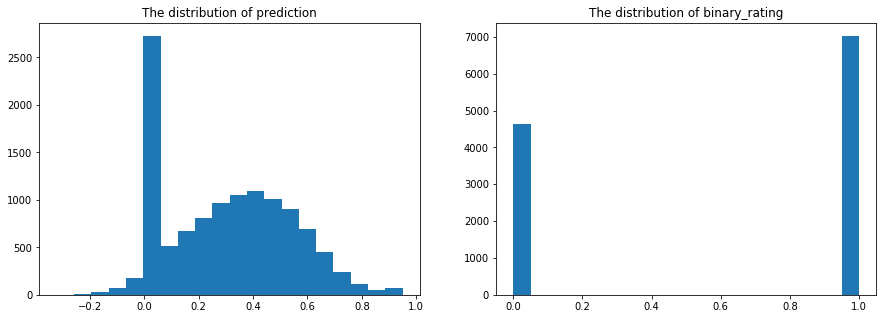

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

best_predictions_pd = best_predictions.toPandas()

# draw the ditrbution of prediction column
axs[0].hist(best_predictions_pd["prediction"], bins=20)
axs[0].set_title("The distribution of prediction")

# draw the ditrbution of rating column
axs[1].hist(best_predictions_pd["rating_binary"], bins=20)
axs[1].set_title("The distribution of binary_rating")

plt.show()

In [17]:
from pyspark.sql.functions import when, col

# define a function to evaluate the model
def evaluate_model(predictions):
    # calculate TP, FP, TN, FN
    TP = predictions.filter((col('prediction_binary') == 1) & (col('rating_binary') == 1)).count()
    FP = predictions.filter((col('prediction_binary') == 1) & (col('rating_binary') == 0)).count()
    TN = predictions.filter((col('prediction_binary') == 0) & (col('rating_binary') == 0)).count()
    FN = predictions.filter((col('prediction_binary') == 0) & (col('rating_binary') == 1)).count()

    # calculate Precision, Recall, F1-Score
    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

    # calculate accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # calculate Specificity
    specificity = TN / (TN + FP) if (TN + FP) else 0

    return accuracy, precision, recall, f1_score, specificity

In [18]:
best_predictions = best_predictions.withColumn('prediction_binary', when(col('prediction') > 0, 1).otherwise(0))
accuracy, precision, recall, f1_score, specificity = evaluate_model(best_predictions)
print("The accuracy of the ALS model is:", accuracy)
print("The precision of the ALS model is:", precision)
print("The recall of the ALS model is:", recall)
print("The f1_score of the ALS model is:", f1_score)
print("The specificity of the ALS model is:", specificity)

The accuracy of the ALS model is: 0.6413183417732383
The precision of the ALS model is: 0.6591010733452594
The recall of the ALS model is: 0.8391459074733096
The f1_score of the ALS model is: 0.7383054668420064
The specificity of the ALS model is: 0.34089926502377865


In [19]:
# normalize the 'prediction' into 0-1

max_prediction = best_predictions.agg({"prediction": "max"}).collect()[0][0]
min_prediction = best_predictions.agg({"prediction": "min"}).collect()[0][0]

best_predictions = best_predictions.withColumn("probability", (best_predictions["prediction"] - min_prediction) / (max_prediction - min_prediction))

best_predictions.show(5)

+--------------------+--------------------+------+----------+--------------+-------+-----------+-------------+-----------------+----------+-----------------+-------------------+
|            business|                user|rating|avg_rating|num_of_reviews|user_id|business_id|rating_binary|__index_level_0__|prediction|prediction_binary|        probability|
+--------------------+--------------------+------+----------+--------------+-------+-----------+-------------+-----------------+----------+-----------------+-------------------+
|0x7952311f0c4d4c8...|11600290564124349...|   5.0|       4.5|           185| 142516|        148|            1|             2538|  0.381872|                1| 0.5534978177422273|
|0x79524b543b6c5f1...|10507195101171315...|   4.0|       4.4|            47|  45191|        471|            0|             7277| 0.4840378|                1| 0.6338017132828261|
|0x7953894b6095618...|10920201230302312...|   4.0|       4.2|           197|  82042|       1088|            0|

In [20]:
# draw the precision-recall curve and ROC curve
from sklearn.metrics import precision_recall_curve, roc_curve, auc

best_predictions_pd = best_predictions.toPandas()

# calculate the precision-recall curve
precision, recall, _ = precision_recall_curve(best_predictions_pd["rating_binary"], best_predictions_pd["probability"])

# calculate the roc curve
fpr, tpr, _ = roc_curve(best_predictions_pd["rating_binary"], best_predictions_pd["probability"])

# calculate the auc
auc_score = auc(fpr, tpr)
print(auc_score)

0.6838633255019978


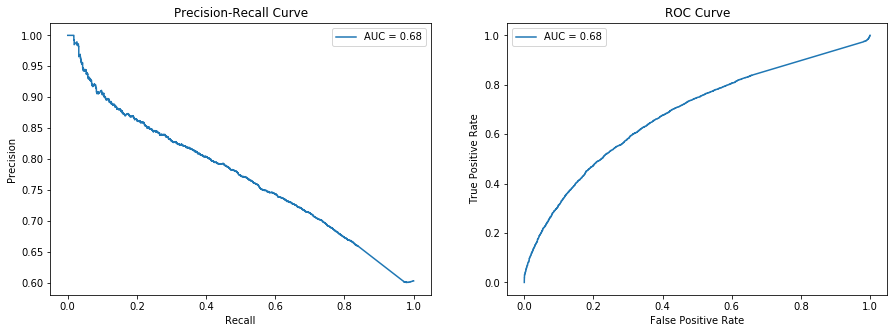

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# draw the precision-recall curve
axs[0].plot(recall, precision, label="AUC = {:.2f}".format(auc_score))
axs[0].set_xlabel("Recall")
axs[0].set_ylabel("Precision")
axs[0].set_title("Precision-Recall Curve")
axs[0].legend()

# draw the roc curve
axs[1].plot(fpr, tpr, label="AUC = {:.2f}".format(auc_score))
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")
axs[1].set_title("ROC Curve")
axs[1].legend()

plt.show()